In [1]:
import pandas as pd

# Đọc dữ liệu
df_train = pd.read_csv(r'/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/fraudTrain.csv')
df_test = pd.read_csv(r'/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/fraudTest.csv')

# Gộp hai tập dữ liệu
df = pd.concat([df_train, df_test])

# In danh sách các features
print(df.columns.tolist())

['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']


In [1]:
# importing necessary libraries for data loading and EDA
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import joblib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix


warnings.filterwarnings('ignore')

In [2]:
# Loading the train data
df_train = pd.read_csv(r'/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/fraudTrain.csv')
df_test = pd.read_csv(r'/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/fraudTest.csv')
df = pd.concat([df_train, df_test])

In [3]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_hour'] = df['trans_date_trans_time'].dt.time.apply(lambda x: str(x)[:2])

df['dob'] = pd.to_datetime(df['dob'])
df['cust_age'] = df['dob'].dt.year.apply(lambda x: 2021-x)
df['cust_age_groups'] = df['cust_age'].apply(lambda x: 'below 10' if x<10 else ('10-20' if x>=10 and x<20 else ('20-30' if x>=20 and x<30 else('30-40' if x>=30 and x<40 else('40-50' if x>=40 and x<50 else('50-60' if x>=50 and x<60 else('60-70' if x>=60 and x<70 else ('70-80' if x>=70 and x<80 else 'Above 80'))))))))


In [4]:
drop_col = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant','first', 'last', 'street', 'city', 'state', 'lat',
       'long','dob', 'unix_time', 'cust_age', 'merch_lat',
       'merch_long', 'city_pop']
df.drop(drop_col, axis = 1, inplace = True)

In [5]:
age_piv_2 = pd.pivot_table(data = df,
                           index = 'cust_age_groups',
                           columns = 'is_fraud',
                           values = 'amt',
                           aggfunc = np.mean)
age_piv_2.sort_values(by = 1, ascending = True, inplace = True)
age_dic = {k:v for (k,v) in zip(age_piv_2.index.values, age_piv_2.reset_index().index.values)}
df['cust_age_groups'] = df['cust_age_groups'].map(age_dic)

In [6]:
merch_cat = df[df['is_fraud'] == 1].groupby('category')['amt'].mean().sort_values(ascending = True)
merch_cat_dic = {k:v for (k,v) in zip(merch_cat.index.values,merch_cat.reset_index().index.values)}
df['category'] = df['category'].map(merch_cat_dic)

In [7]:
job_txn_piv_2 = pd.pivot_table(data = df,
                               index = 'job',
                               columns = 'is_fraud',
                               values= 'amt',
                               aggfunc = np.mean)
job_cat_dic = {k:v for (k,v) in zip(job_txn_piv_2.index.values, job_txn_piv_2.reset_index().index.values)}
df['job'] = df['job'].map(job_cat_dic)


In [8]:
df['trans_hour'] = df['trans_hour'].astype('int')
df = pd.get_dummies(data  = df, columns = ['gender'], drop_first = True, dtype = 'int')

# Train_test_split

In [9]:
train,test = train_test_split(df, test_size=0.33, random_state=42, stratify = df['is_fraud'])
# visualizing class imbalance
df['is_fraud'].value_counts()
# check
print(train.shape)
print(test.shape)

# let's drop transaction number columns from both the training and testing data
train.drop('trans_num',axis = 1, inplace = True)
test.drop('trans_num',axis = 1, inplace = True)
# splitting data into dependent and independent features respectively
y_train = train['is_fraud']
X_train = train.drop('is_fraud',axis = 1)

y_test = test['is_fraud']
X_test = test.drop('is_fraud',axis = 1)

print('Shape of training data: ',(X_train.shape,y_train.shape))
print('Shape of testing data: ',(X_test.shape,y_test.shape))

(1241103, 9)
(611291, 9)
Shape of training data:  ((1241103, 7), (1241103,))
Shape of testing data:  ((611291, 7), (611291,))


In [10]:
sc = StandardScaler()
# scaling the training and testing data
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
# convert them into dataframes
X_train_sc = pd.DataFrame(data = X_train_sc, columns = X_train.columns)
X_test_sc = pd.DataFrame(data = X_test_sc, columns = X_test.columns)

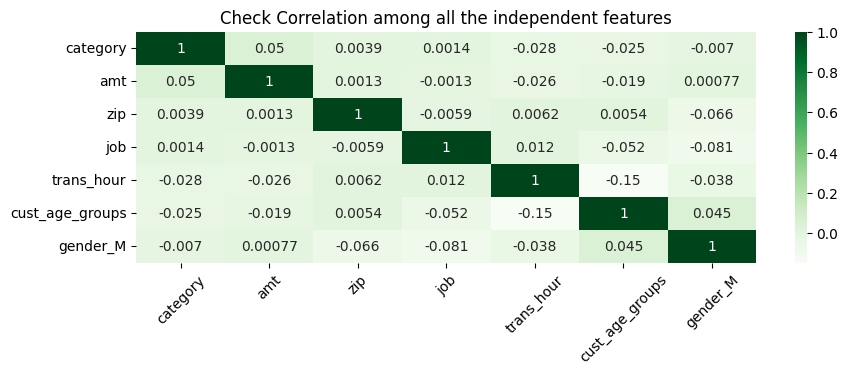

In [11]:
# check correlation among all the independent features in train data
plt.figure(figsize = (10,3))
plt.title("Check Correlation among all the independent features")
sns.heatmap(X_train_sc.corr(),annot = True, cmap = 'Greens')
plt.xticks(rotation = 45)
plt.show()

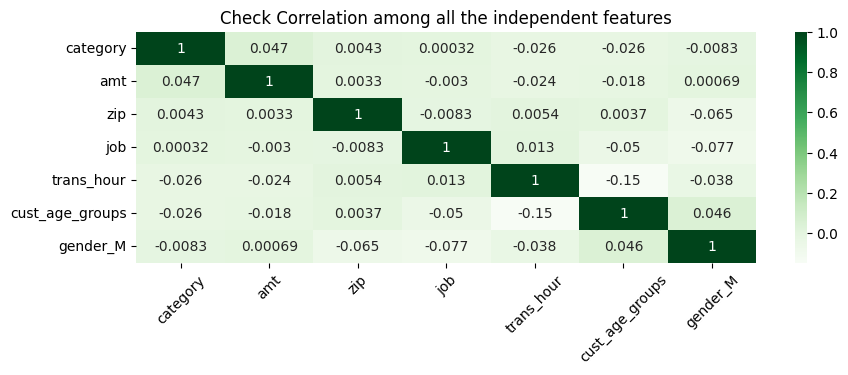

In [12]:
plt.figure(figsize = (10,3))
plt.title("Check Correlation among all the independent features")
sns.heatmap(X_test_sc.corr(),annot = True, cmap = 'Greens')
plt.xticks(rotation = 45)
plt.show()

# Logistic Regression

In [13]:
lr = LogisticRegression(class_weight = 'balanced')# fitting on the training data
lr.fit(X_train_sc,y_train)

y_pred_train_proba = lr.predict_proba(X_train_sc)
y_pred_test_proba = lr.predict_proba(X_test_sc)

y_train_results = pd.DataFrame(y_pred_train_proba, columns = ['pred_not_fraud','pred_fraud'])
y_test_results = pd.DataFrame(y_pred_test_proba, columns = ['pred_not_fraud','pred_fraud'])

y_train_results['y_train_actual'] = y_train.values
y_test_results['y_test_actual'] = y_test.values


In [14]:
# Let's create columns with different probability cutoffs 
numbers = [0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in numbers:
    y_train_results[i]= y_train_results.pred_fraud.map(lambda x: 1 if x > i else 0)
    y_test_results[i] = y_test_results.pred_fraud.map(lambda x: 1 if x > i else 0)
cutoff_df = pd.DataFrame(columns=['Threshold', 'precision_score', 'recall_score', 'F1_score', 'Accuracy'])

In [15]:
for i in numbers:
    cm1 = confusion_matrix(y_train_results['y_train_actual'], y_train_results[i])
    TP, FP, FN, TN = cm1[1,1], cm1[0,1], cm1[1,0], cm1[0,0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score_value = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    cutoff_df.loc[i] = [i, precision, recall, f1_score_value, accuracy]

print(cutoff_df)

best_idx = cutoff_df['F1_score'].idxmax()
best_threshold = cutoff_df.loc[best_idx, 'Threshold']
best_f1_score = cutoff_df.loc[best_idx, 'F1_score']
best_precision = cutoff_df.loc[best_idx, 'precision_score']
best_recall = cutoff_df.loc[best_idx, 'recall_score']
best_accuracy = cutoff_df.loc[best_idx, 'Accuracy']
best_auc = roc_auc_score(y_train_results['y_train_actual'], y_train_results[best_threshold])

print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best Accuracy: {best_accuracy:.4f}')
print(f'Best Precision: {best_precision:.4f}')
print(f'Best Recall: {best_recall:.4f}')
print(f'Best F1 Score: {best_f1_score:.4f}')
print(f'Best ROC_AUC Score: {best_auc:.4f}')

      Threshold  precision_score  recall_score  F1_score  Accuracy
0.10       0.10         0.006505      1.000000  0.012926  0.204321
0.15       0.15         0.007676      0.984380  0.015233  0.336916
0.20       0.20         0.009335      0.955459  0.018490  0.471528
0.30       0.30         0.013533      0.892824  0.026662  0.660375
0.40       0.40         0.018093      0.772812  0.035358  0.780312
0.50       0.50         0.048219      0.750541  0.090615  0.921517
0.60       0.60         0.110437      0.726260  0.191720  0.968096
0.70       0.70         0.140375      0.634705  0.229903  0.977847
0.80       0.80         0.149672      0.515311  0.231969  0.982222
0.90       0.90         0.177575      0.488401  0.260454  0.985550
Best Threshold: 0.9000
Best Accuracy: 0.9855
Best Precision: 0.1776
Best Recall: 0.4884
Best F1 Score: 0.2605
Best ROC_AUC Score: 0.7383


In [16]:
for i in numbers:
    cm1 = confusion_matrix(y_test_results['y_test_actual'], y_test_results[i])
    TP, FP, FN, TN = cm1[1,1], cm1[0,1], cm1[1,0], cm1[0,0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score_value = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    cutoff_df.loc[i] = [i, precision, recall, f1_score_value, accuracy]

print(cutoff_df)

best_idx = cutoff_df['F1_score'].idxmax()
best_threshold = cutoff_df.loc[best_idx, 'Threshold']
best_f1_score = cutoff_df.loc[best_idx, 'F1_score']
best_precision = cutoff_df.loc[best_idx, 'precision_score']
best_recall = cutoff_df.loc[best_idx, 'recall_score']
best_accuracy = cutoff_df.loc[best_idx, 'Accuracy']
best_auc = roc_auc_score(y_test_results['y_test_actual'], y_test_results[best_threshold])

print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best Accuracy: {best_accuracy:.4f}')
print(f'Best Precision: {best_precision:.4f}')
print(f'Best Recall: {best_recall:.4f}')
print(f'Best F1 Score: {best_f1_score:.4f}')
print(f'Best ROC_AUC Score: {best_auc:.4f}')

      Threshold  precision_score  recall_score  F1_score  Accuracy
0.10       0.10         0.006511      1.000000  0.012939  0.205035
0.15       0.15         0.007695      0.985871  0.015271  0.337523
0.20       0.20         0.009291      0.952276  0.018402  0.470676
0.30       0.30         0.013437      0.891052  0.026475  0.658562
0.40       0.40         0.018199      0.779906  0.035569  0.779637
0.50       0.50         0.048853      0.762951  0.091826  0.921370
0.60       0.60         0.111358      0.740659  0.193607  0.967853
0.70       0.70         0.140772      0.644898  0.231098  0.977641
0.80       0.80         0.150329      0.523391  0.233572  0.982103
0.90       0.90         0.180592      0.496075  0.264790  0.985647
Best Threshold: 0.9000
Best Accuracy: 0.9856
Best Precision: 0.1806
Best Recall: 0.4961
Best F1 Score: 0.2648
Best ROC_AUC Score: 0.7421


🔹 Các feature quan trọng nhất trong mô hình:
          Features  Coefficient
1              amt     1.610103
0         category    -0.800480
4       trans_hour    -0.097140
5  cust_age_groups     0.060657
6         gender_M    -0.049114
3              job    -0.010078
2              zip    -0.005858


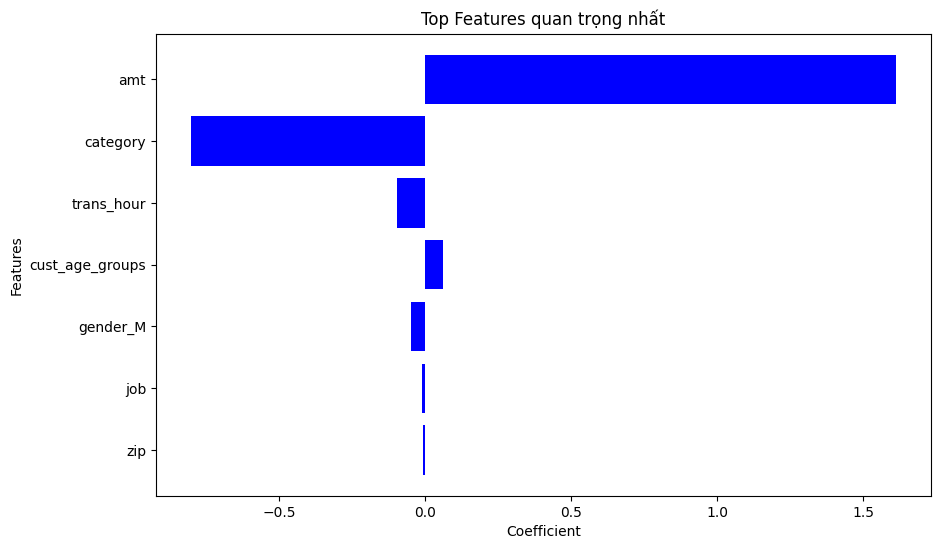

In [17]:
#Tính Feature Importance từ Logistic Regression
feature_importance = pd.DataFrame({
    'Features': X_train.columns,
    'Coefficient': lr.coef_[0]  # Hệ số của từng feature trong mô hình
})

#Sắp xếp các feature theo mức độ ảnh hưởng (giá trị tuyệt đối của hệ số)
feature_importance['abs_coeff'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='abs_coeff', ascending=False)

# ✅ In ra danh sách các feature quan trọng
print("🔹 Các feature quan trọng nhất trong mô hình:")
print(feature_importance[['Features', 'Coefficient']].head(10))  # In 10 feature quan trọng nhất

# 📊 Vẽ biểu đồ thể hiện mức độ quan trọng của feature
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Features'][:10], feature_importance['Coefficient'][:10], color='blue')
plt.xlabel("Coefficient")
plt.ylabel("Features")
plt.title("Top Features quan trọng nhất")
plt.gca().invert_yaxis()  # Đảo ngược trục Y để feature quan trọng nhất nằm trên cùng
plt.show()

# 